In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from scipy import special, integrate
import os
import sys

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools
from photxspec import construct_photometric_sample

### construct samples

In [3]:
# inputs
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift) # initialize simulation

sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]  # 5 redshift error bins in SPHEREx

In [4]:
# tack on multiple spectroscopic samples to extend the box
def box(gal_pos_spec, boxsize, i):
    box = gal_pos_spec.copy()
    box[:,2] += i * sim.boxsize
    return box

def append_boxes(gal_pos_spec, boxsize, n=2):
    sample = gal_pos_spec.copy()
    for i in range(n):
        oneside = box(gal_pos_spec, boxsize, i+1)
        otherside = box(gal_pos_spec, boxsize, -(i+1))
        sample = np.concatenate((sample, oneside, otherside))
    return sample

Check out the extra boxes along the LOS, and the resulting photometric samples:

 number density for SPHEREx at z=0.5: 5.01e-04 (h/Mpc)^3 
target number of subhalos: 4316
 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186
 number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.5: 3.27e-03 (h/Mpc)^3 
target number of subhalos: 28171


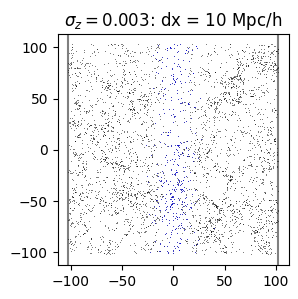

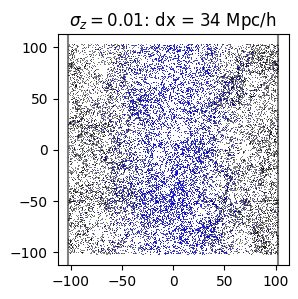

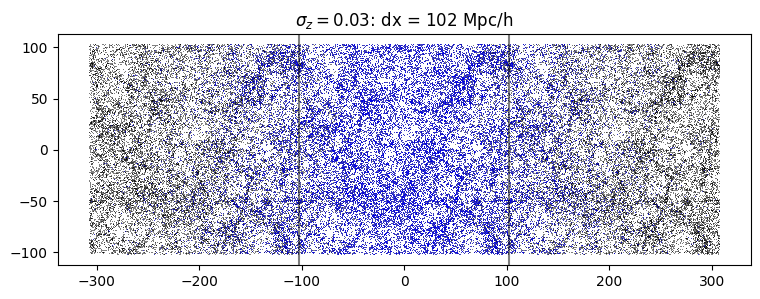

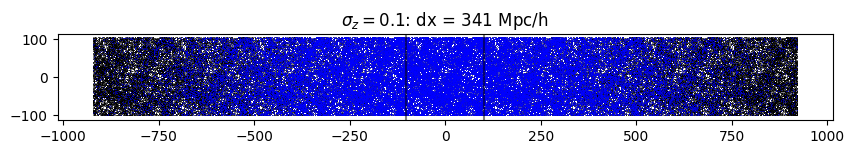

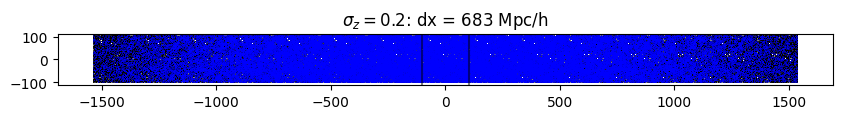

In [5]:
ns = [0,0,1,4,7]
for i, sigma_z in enumerate(sigma_zs):
    # spectroscopic sample
    gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
    gal_pos_spec -= sim.boxsize / 2
    
    # extend the box
    sample = append_boxes(gal_pos_spec, sim.boxsize, n=ns[i])

    # dx: redshift error in comoving units
    dx = tools.get_dx(redshift, sigma_z)

    # construct photometric sample
    gal_pos_phot = construct_photometric_sample(sample, dx, sim.boxsize)
    
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(sample[:,2], sample[:,0], color='k', marker=',', ls='None', alpha=0.5)
    ax.plot(gal_pos_phot[:,2], gal_pos_phot[:,0], color='b', marker=',', ls='None', alpha=0.5)
    ax.axvline(-sim.boxsize.value/2, c='k', alpha=0.5)
    ax.axvline(sim.boxsize.value/2, c='k', alpha=0.5)
    ax.set_aspect('equal')
    ax.set_title(r'$\sigma_z =$'f'{sigma_z}: dx = {dx.value:.0f} Mpc/h')

#### take one $\sigma_z$

In [5]:
sigma_z = sigma_zs[2]
sigma_z

0.03

In [6]:
# how many boxes to add on either side?
#  be extra generous so if we add one more box (cell below) we'll have
#    > a boxsize of spectroscopic galaxies on either side of the photometric tails
n = 1

In [16]:
# dx: redshift error in comoving units
dx = tools.get_dx(redshift, sigma_z)

# spectroscopic sample
gal_pos = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos -= sim.boxsize / 2

# extend the box:
#  add an extra so we have > a boxsize of spectroscopic galaxies on either side of the photometric tails
gal_pos_spec = append_boxes(gal_pos, sim.boxsize, n=n+1)

# construct photometric sample
gal_pos_phot = construct_photometric_sample(gal_pos_spec, dx)

 number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186


In [17]:
# divide into 2D slices along the LOS:
nslices = (n+2) * 11
losbins = np.linspace(-(n+1/2) * sim.boxsize, (n+1/2) * sim.boxsize, nslices+1)
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << dx.unit

In [18]:
slicewidth

<Quantity 18.63636364 Mpc / littleh>

Text(0.5, 1.0, 'Photometric and spectroscopic samples: $\\sigma_z =$0.03: dx = 102 Mpc/h')

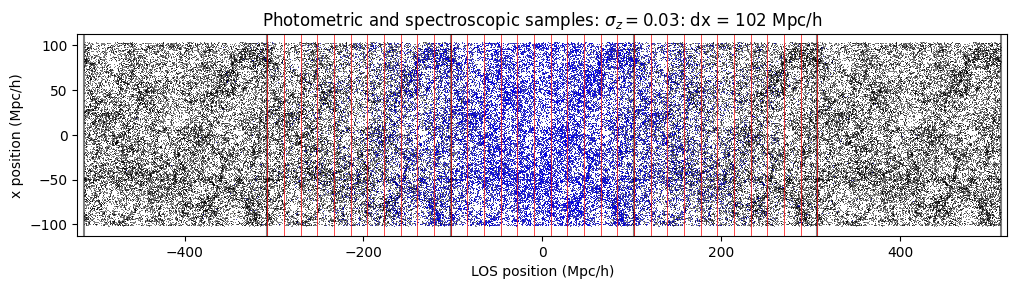

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(gal_pos_spec[:,2], gal_pos_spec[:,0], color='k', marker=',', ls='None', alpha=0.5)
ax.plot(gal_pos_phot[:,2], gal_pos_phot[:,0], color='b', marker=',', ls='None', alpha=0.5)
for i in range(n+2):
    ax.axvline(-(2*i+1)/2 * sim.boxsize.value, c='k', alpha=0.5)
    ax.axvline((2*i+1)/2 * sim.boxsize.value, c='k', alpha=0.5)
for edge in losbins:
    ax.axvline(edge.value, c='r', lw=0.5)
ax.set_xlim(-520,520)
ax.set_xlabel('LOS position (Mpc/h)')
ax.set_ylabel('x position (Mpc/h)')
ax.set_aspect('equal')
ax.set_title(r'Photometric and spectroscopic samples: $\sigma_z =$'f'{sigma_z}: dx = {dx.value:.0f} Mpc/h')

In [20]:
# comoving distance to box center
r_dist = tools.redshift_to_comov(sim.redshift).to(dx.unit)

# write a function since now we have to make multiple photometric samples (from different LOS ranges)
def get_ra_dec(sample, chi):
    # convert photometric sample to (RA,Dec), setting LOS positions to box center
    s = np.copy(sample)
    s[:,2] = 0 * s.unit
    if isinstance(chi, u.Quantity):
        observer = np.array([0, 0, chi.value]) << chi.unit
    else:
        observer = np.array([0, 0, chi])
    ra, dec = tools.CartesiantoEquatorial(s, observer)
    return ra, dec

In [21]:
# construct sample for each slice
widths = sim.boxsize * np.array([0.25, 0.5, 1]) # how wide do we want each photometric sample to be?
phot_samples = []
spec_samples = []
for i, slice_center in enumerate(slice_centers):
    width_results = []
    for j, width in enumerate(widths):
        # photometric sample
        # bounds for the LOS position for this sample
        bounds = (slice_center - width/2, slice_center + width/2)
        idx = (bounds[0] <= gal_pos_phot[:,2]) & (gal_pos_phot[:,2] < bounds[1])
        ra_, dec_ = get_ra_dec(gal_pos_phot[idx], r_dist)
        width_results.append(np.array([ra_, dec_]).T << ra_.unit)
    phot_samples.append(width_results)

    # spectroscopic sample
    idx = (losbins[i] <= gal_pos_spec[:,2]) & (gal_pos_spec[:,2] < losbins[i+1])
    ra_, dec_ = get_ra_dec(gal_pos_spec[idx], r_dist)
    spec_samples.append(np.array([ra_, dec_]).T << ra_.unit)

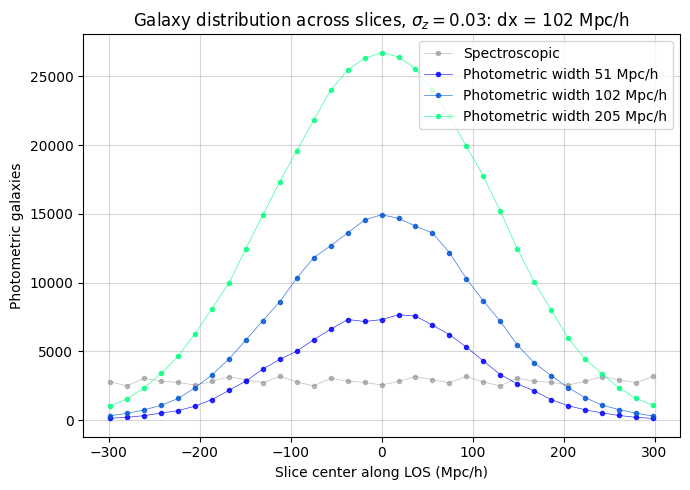

In [22]:
norm = mpl.colors.Normalize(vmin=min(widths.value), vmax=max(widths.value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='winter')
fig, ax = plt.subplots(figsize=(7,5))
nspecgals = [
    len(x) for x in spec_samples
]
ax.plot(slice_centers, nspecgals, '.-', c='grey', lw=0.5, alpha=0.5, label='Spectroscopic')
for j, width in enumerate(widths):
    nphotgals = [
        len(phot_samples[i][j]) for i in range(nslices)
    ]
    ax.plot(slice_centers, nphotgals, '.-', lw=0.5, alpha=0.8, c=smap.to_rgba(width.value),
            label=f'Photometric width {width.value:.0f} Mpc/h')
ax.grid(alpha=0.5)
ax.set_xlabel('Slice center along LOS (Mpc/h)')
ax.set_ylabel('Photometric galaxies')
ax.set_title(r'Galaxy distribution across slices, $\sigma_z =$'f'{sigma_z}: dx = {dx.value:.0f} Mpc/h')
ax.legend()
fig.tight_layout()

Text(0.5, 0.98, 'Photometric samples')

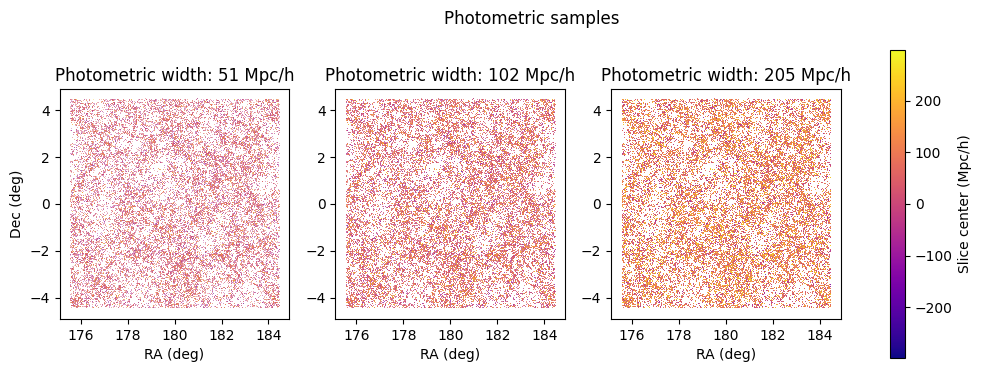

In [23]:
norm = mpl.colors.Normalize(vmin=min(slice_centers.value), vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma')
fig = plt.figure(figsize=(4.2 * len(widths),4))
axs = {}
for j, width in enumerate(widths):
    axs[j] = fig.add_subplot(1, len(widths), j+1)
    for i, phot_sample in enumerate(phot_samples):
        axs[j].plot(phot_sample[j][:,0], phot_sample[j][:,1], marker=',', ls='None', alpha=0.2,
                    c=smap.to_rgba(slice_centers[i].value))
        axs[j].set_title(f"Photometric width: {width.value:.0f} Mpc/h")
        
for j in range(len(axs)):
    axs[j].set_aspect('equal')
    axs[j].set_xlabel('RA (deg)')
axs[0].set_ylabel('Dec (deg)')
fig.colorbar(smap, ax=[axs[0], axs[1], axs[2]], label='Slice center (Mpc/h)')
fig.suptitle('Photometric samples')

51.25 Mpc / littleh
102.5 Mpc / littleh
205.0 Mpc / littleh


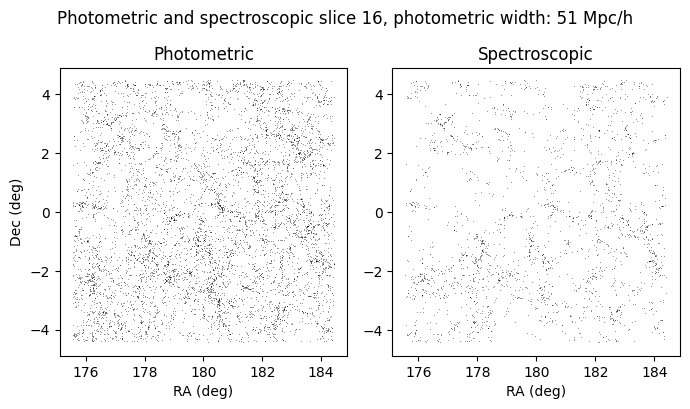

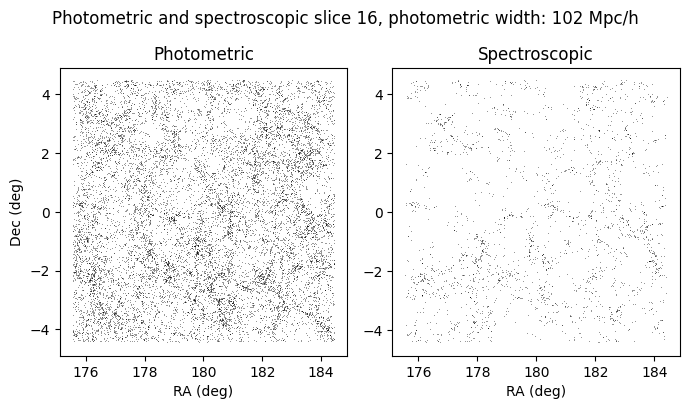

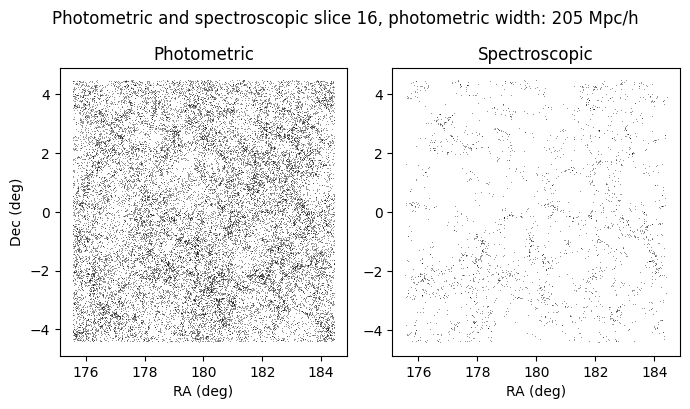

In [24]:
# separation bins
nbins = 20
thetamin = 0.001
thetamax = 4.
bins = np.logspace(np.log10(thetamin), np.log10(thetamax), nbins+1)

xcorrs = np.empty((len(widths), nslices, nbins))
for j, width in enumerate(widths):
    print(width)
    for i in range(nslices):
        # prep photometric and spectroscopic slices and corresponding random set
        nd1 = len(phot_samples[i][j])
        ra_phot, dec_phot = phot_samples[i][j].T
        nd2 = len(spec_samples[i])
        ra_spec, dec_spec = spec_samples[i].T
        ra_rand_phot = np.random.uniform(min(ra_phot.value), max(ra_phot.value), len(ra_phot)) << ra_phot.unit
        dec_rand_phot = np.random.uniform(min(dec_phot.value), max(dec_phot.value), len(dec_phot)) << ra_phot.unit

        if i==nslices//2:
            fig, axs = plt.subplots(1, 2, figsize=(7,4))
            axs[0].plot(ra_phot, dec_phot, marker=',', ls='None', c='k', alpha=0.4)
            axs[0].set_title('Photometric')
            axs[0].set_ylabel('Dec (deg)')
            axs[1].plot(ra_spec, dec_spec, marker=',', ls='None', c='k', alpha=0.4)
            axs[1].set_title('Spectroscopic')
            for ax in axs:
                ax.set_aspect('equal')
                ax.set_xlabel('RA (deg)')
            fig.suptitle(f'Photometric and spectroscopic slice {i}, photometric width: {width.value:.0f} Mpc/h')
            fig.tight_layout()

        # compute xcorr
        thetaavg, xcorrs[j,i] = corrfuncs.wtheta_cross_PH(ra_phot.value, dec_phot.value, ra_spec.value, dec_spec.value,
                                          ra_rand_phot.value, dec_rand_phot.value, bins)

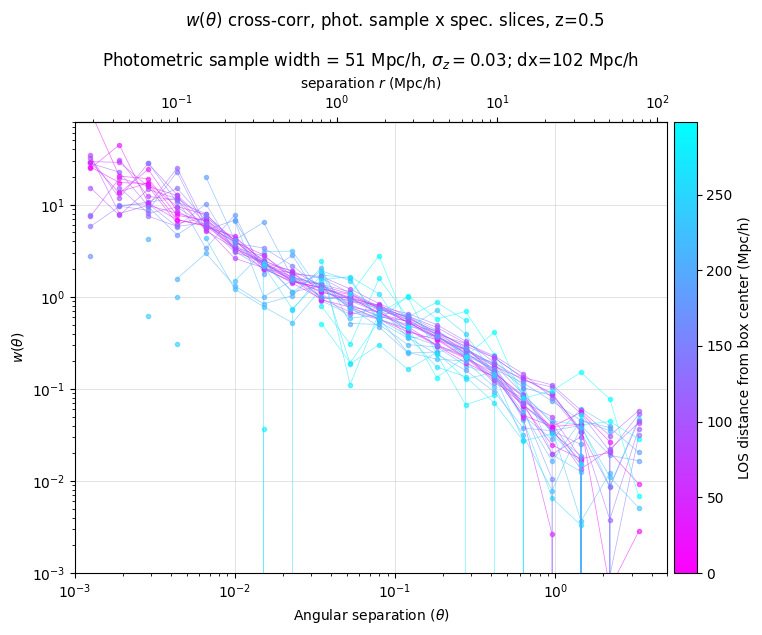

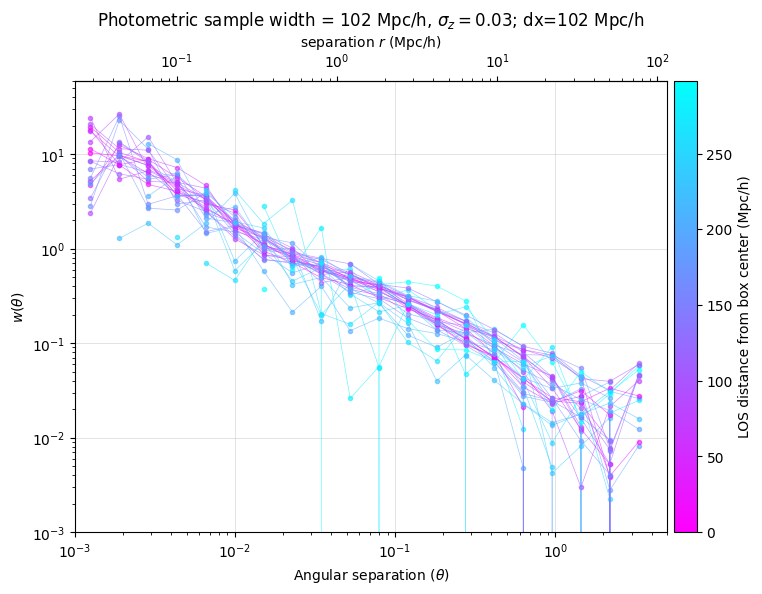

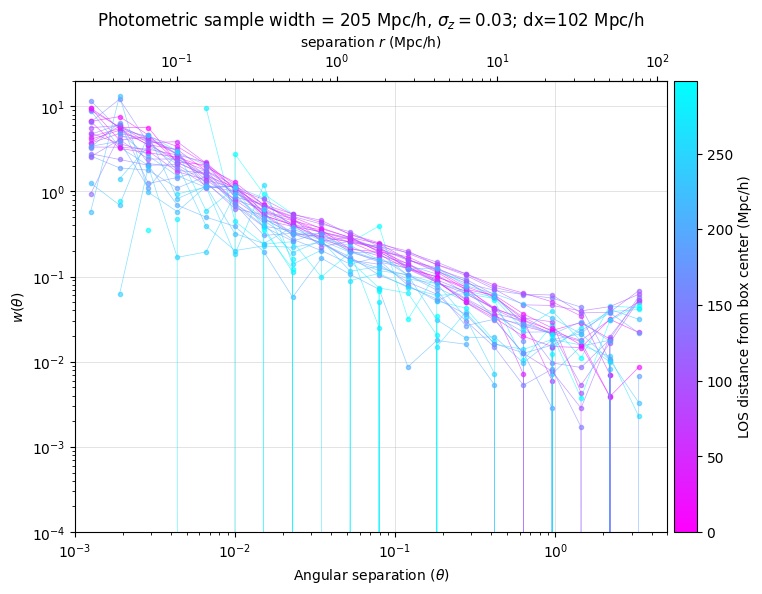

In [25]:
# color map and theta/r conversion for plotting
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift).value

ylims = [(1e-3,8e1), (1e-3,6e1), (1e-4,2e1)]
for j, width in enumerate(widths):
    fig, ax = plt.subplots(figsize=(8,6))

    # cross correlation in each slice for this sigma_z
    for i, xcorr_slice in enumerate(xcorrs[j]):
        ax.plot(thetaavg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=smap.to_rgba(np.abs(slice_centers.value[i])))
    secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.set_xlabel(r'Angular separation ($\theta$)')
    ax.set_xlim(1e-3,5.)
    ax.set_ylim(ylims[j])
    ax.loglog()
    ax.set_title(f'Photometric sample width = {widths[j].value:.0f} Mpc/h, ' \
                 r'$\sigma_z=$'+f'{sigma_z}; dx={dx.value:.0f} Mpc/h')
    ax.grid(alpha=0.5, lw=0.5)

    ax.set_ylabel(r'$w(\theta)$')
    fig.tight_layout()
    fig.colorbar(smap, ax=ax, pad=0.01, label='LOS distance from box center (Mpc/h)')
    if j==0:
        fig.suptitle(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, 'f'z={redshift}', y=1.05)

#### results with the full photometric sample

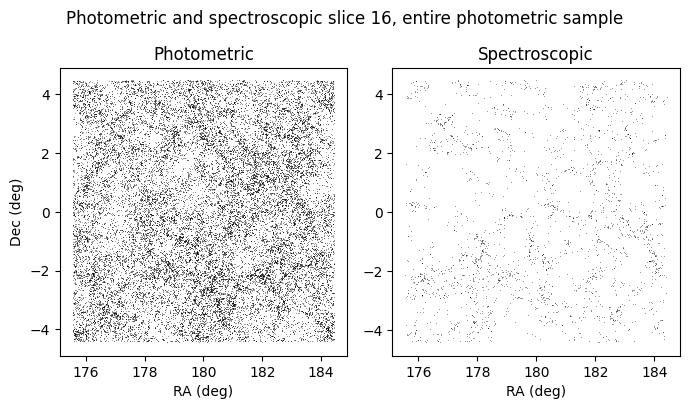

In [22]:
# separation bins
nbins = 20
thetamin = 0.001
thetamax = 4.
bins = np.logspace(np.log10(thetamin), np.log10(thetamax), nbins+1)

xcorrs = np.empty((nslices, nbins))
for i in range(nslices):
    # prep photometric and spectroscopic slices and corresponding random set
    nd1 = len(gal_pos_phot)
    ra_phot, dec_phot = get_ra_dec(gal_pos_phot, r_dist)
    nd2 = len(spec_samples[i])
    ra_spec, dec_spec = spec_samples[i].T
    ra_rand_phot = np.random.uniform(min(ra_phot.value), max(ra_phot.value), len(ra_phot)) << ra_phot.unit
    dec_rand_phot = np.random.uniform(min(dec_phot.value), max(dec_phot.value), len(dec_phot)) << ra_phot.unit

    if i==nslices//2:
        fig, axs = plt.subplots(1, 2, figsize=(7,4))
        axs[0].plot(ra_phot, dec_phot, marker=',', ls='None', c='k', alpha=0.4)
        axs[0].set_title('Photometric')
        axs[0].set_ylabel('Dec (deg)')
        axs[1].plot(ra_spec, dec_spec, marker=',', ls='None', c='k', alpha=0.4)
        axs[1].set_title('Spectroscopic')
        for ax in axs:
            ax.set_aspect('equal')
            ax.set_xlabel('RA (deg)')
        fig.suptitle(f'Photometric and spectroscopic slice {i}, entire photometric sample')
        fig.tight_layout()

    # compute xcorr
    thetaavg, xcorrs[i] = corrfuncs.wtheta_cross_PH(ra_phot.value, dec_phot.value, ra_spec.value, dec_spec.value,
                                      ra_rand_phot.value, dec_rand_phot.value, bins)

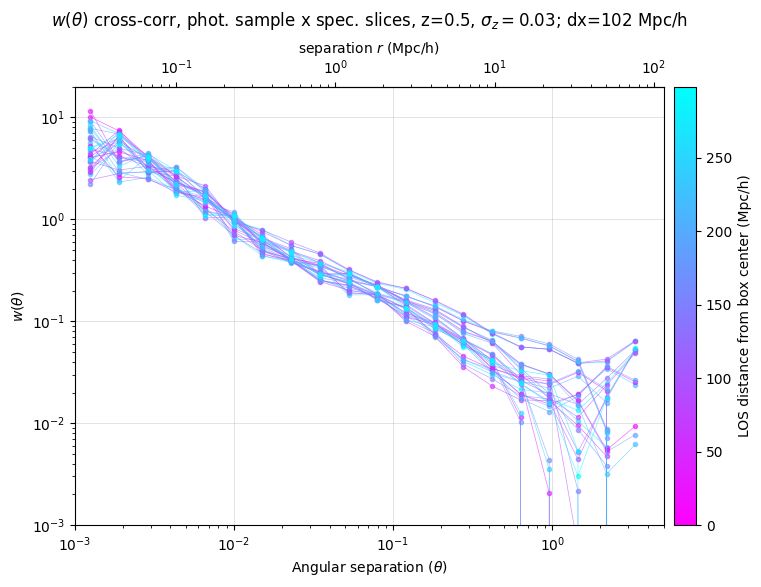

In [30]:
# color map and theta/r conversion for plotting
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift).value

fig, ax = plt.subplots(figsize=(8,6))

# cross correlation in each slice for this sigma_z
for i, xcorr_slice in enumerate(xcorrs):
    ax.plot(thetaavg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=smap.to_rgba(np.abs(slice_centers.value[i])))
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_xlabel(r'Angular separation ($\theta$)')
ax.set_xlim(1e-3,5.)
ax.set_ylim(1e-3,2e1)
ax.loglog()
ax.set_title(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, 'f'z={redshift}, '+ \
             r'$\sigma_z=$'+f'{sigma_z}; dx={dx.value:.0f} Mpc/h', y=1.12)
ax.grid(alpha=0.5, lw=0.5)

ax.set_ylabel(r'$w(\theta)$')
fig.tight_layout()
fig.colorbar(smap, ax=ax, pad=0.015, label='LOS distance from box center (Mpc/h)')